Authors: 
- Andreas Rosenquist (s214604)
- Felix Lund Frandsen (s214584)
- Kasper Rønberg (s214786)

### Work distribution

| Student Number | Part 1 | Part 2 | Part 3 | Part 4 |
|----------------|--------|--------|--------|--------|
| s214604        | 80%    | 10%    | 80%    | 10%    |
| s214584        | 10%    | 45%    | 80%    | 10%    |
| s214786        | 10%    | 45%    | 80%    | 10%    |


# Part 1: Analyze the network

The following section seeks to investigate the nature of the rock performers network. _Note some of the plots are extra large to be able to view the content of the many nodes_

In [ ]:
import networkx as nx
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import powerlaw
import backboning
from collections import Counter
import mwparserfromhell
from wordcloud import WordCloud
from pathlib import Path
import json
import os


# Try to import WordCloud, provide fallback if not available
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("WordCloud not available. Will use text-based alternative.")

github_repo = "https://github.com/Kasper1616/social_graphs_a2"


BASE = Path(os.getcwd())
PAGES = BASE / "artist_pages_wikitext"
artist_genres = json.loads((BASE / "artist_genres.json").read_text(encoding="utf-8"))
rows = [r for r in json.loads((BASE / "artist_pages_index.json").read_text(encoding="utf-8")) if r.get("status") in {"ok", "skipped-existing"}]
row_lookup = {}
for r in rows:
    k = r.get("input") or r.get("label") or r.get("title")
    if k:
        row_lookup[k] = r

#### Helper functions

In [ ]:
import re
from typing import Iterable

TOKEN_RE = re.compile(r"[A-Za-z']+")
STOPWORDS = set("the and of in to a for on by with from at an is are be as it that their was were this which its has have had also but or who he she they his her them not into over after during between through while been more than other such may can both these those including often first second since because upon former latter per each where when how many most some two three four five six seven eight nine ten ref citation needed band album albums song songs tour tours records record release released label labels years year music musical rock artist artists group groups sound known".split())

def modularity(graph, partition):
    m = graph.number_of_edges()
    if not m:
        return 0.0
    degrees = dict(graph.degree())
    buckets = {}
    for node, comm in partition.items():
        if node in graph:
            buckets.setdefault(comm, set()).add(node)
    return sum(graph.subgraph(nodes).number_of_edges() / m - (sum(degrees[n] for n in nodes) / (2 * m)) ** 2 for nodes in buckets.values())

def tokenize(text):
    return [t for t in TOKEN_RE.findall(text.lower()) if t.isalpha() and t not in STOPWORDS and len(t) > 2]

def strip_text(text: str) -> str:
    return mwparserfromhell.parse(text).strip_code(normalize=True, collapse=True)

FILENAME_SANITIZE_RE = re.compile(r"[^A-Za-z0-9_()\-]")

def _candidate_filenames(base: str) -> list[str]:
    name = Path(base).name
    candidates = [name]
    if "'" in name:
        candidates.append(name.replace("'", "_"))
        candidates.append(name.replace("'", ""))
    stem, suffix = Path(name).stem, Path(name).suffix or ".txt"
    cleaned = FILENAME_SANITIZE_RE.sub("_", stem)
    if cleaned:
        candidates.append(f"{cleaned}{suffix}")
    normalized = re.sub(r"_+", "_", cleaned).strip("_")
    if normalized and normalized != cleaned:
        candidates.append(f"{normalized}{suffix}")
    if normalized and "_" in normalized:
        candidates.append(normalized.replace("_", " ") + suffix)
    return list(dict.fromkeys(candidates))

def page_path(row: dict) -> Path:
    base = row.get("file") or f"{row.get('input') or row.get('label') or row.get('title')}.txt"
    for candidate in _candidate_filenames(base):
        path = PAGES / candidate
        if path.exists():
            return path
    return PAGES / Path(base).name

def tokens_for(artist):
    row = row_lookup.get(artist)
    if not row:
        return []
    plain = strip_text(page_path(row).read_text(encoding="utf-8", errors="ignore"))
    return tokenize(plain)

In [2]:
# Import the rock performers graph
wkd = os.getcwd()

G = nx.read_gml('rock_performers_graph.gml')

### Degree Distributions

We first acknowlegde the general degree distribution of the network which we also did in previous assignment, but the code has again been included to give us an initial idea of the behaviour of each artist, and further considerations has been made.

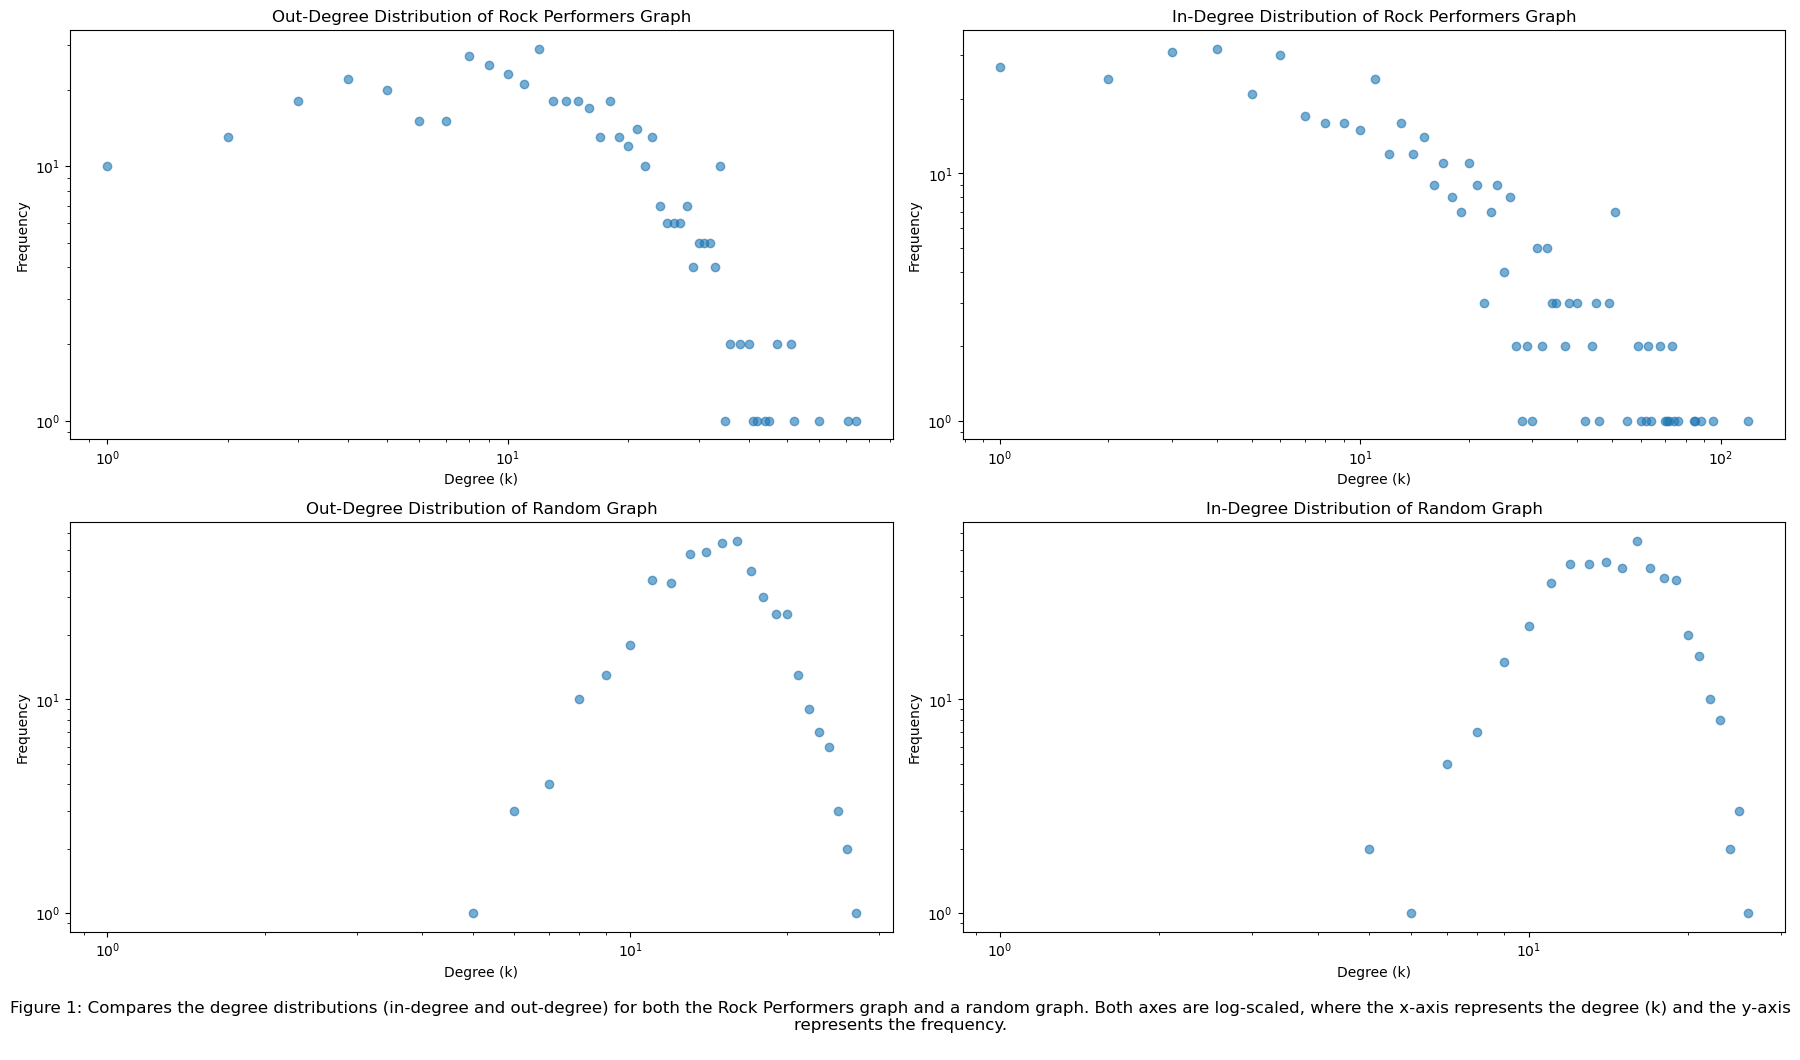

In [3]:
# Reference graphs for comparison
random_graph = nx.gnm_random_graph(
    G.number_of_nodes(), G.number_of_edges(), 
    directed=True
    )



in_degrees_G = [d for n, d in G.in_degree()]
out_degrees_G = [d for n, d in G.out_degree()]

out_degrees_random = [d for n, d in random_graph.out_degree()]
in_degrees_random = [d for n, d in random_graph.in_degree()]

def plot_degree_distribution(degrees, title, ax, xlabel='Degree (k)', ylabel='Frequency'):
    bins, edges = np.histogram(degrees, bins=range(1, max(degrees)+2))
    ax.scatter(edges[:-1], bins, marker='o', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('log')
    ax.set_yscale('log')

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
plot_degree_distribution(out_degrees_G, 'Out-Degree Distribution of Rock Performers Graph', axs[0, 0])
plot_degree_distribution(in_degrees_G, 'In-Degree Distribution of Rock Performers Graph', axs[0, 1])
plot_degree_distribution(out_degrees_random, 'Out-Degree Distribution of Random Graph', axs[1, 0])
plot_degree_distribution(in_degrees_random, 'In-Degree Distribution of Random Graph', axs[1, 1])
txt = f"Figure 1: Compares the degree distributions (in-degree and out-degree) for both the Rock Performers graph and a random graph. Both axes are log-scaled, where the x-axis represents the degree (k) and the y-axis represents the frequency.\n"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()

Firstly, the rock performer network clearly deviates from a random network which is to be expected. Moreover there is a clear difference in the amount of nodes with many in-degrees and out-degrees which would indicate that it is more common that an artist is being referenced in a Wikipedia page than an artist referencing another artist.

In terms of network science, we see that the random network seems to follow a poisson distribution while the in- and out-degrees of the rock performer network seem to be closer to the scale-free regime or at least the expected distribution from those networks. Although, the distribution of the out-degrees does not seem to clearly deviate from the properties of the random regime. 

In [4]:
# Fit power-law distributions
in_fit = powerlaw.Fit(in_degrees_G, discrete=True)
out_fit = powerlaw.Fit(out_degrees_G, discrete=True)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/opt/homebrew/Caskroom/miniforge/base/envs/socialgraphs/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/homebrew/Caskroom/miniforge/base/envs/socialgraphs/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [5]:
print("\nPower-law fit results:"
      f"\nIn-Degree: alpha={in_fit.power_law.alpha:.2f}"
      f"\nOut-Degree: alpha={out_fit.power_law.alpha:.2f}")


Power-law fit results:
In-Degree: alpha=2.63
Out-Degree: alpha=3.88


Further investigating the distribution of the in- and out-degrees of the rock performer network, the degree exponent of a powerlaw fit for the out-degrees does indeed lie well within the boundaries of being considered random regime with an $\gamma = 3.88$. However, the powerlaw fit for in-degrees does seem to have the properties of a scale-free network as $\gamma = 2.63$. Due to this, it could be argued that there is some randomness to the out-degrees, as not all relations for a specific artist could possibly be mentioned in a Wikipedia page. Although, there is no specific structure between the authors of the Wikipedia pages, one could assume that when a reference is made, they would begin with the most prevelant artists, i.e. most popular or influential artists, and that is why we see some kind of scale-free structure of in-degress which is not seen for the out-degrees. 

This raises the following question:

**Why would we in this case consider both the in- and out-degrees, i.e. why are we interested in a directed network?** 

We believe that the direction of the connection does matter; An in-degree of a node would usually denote an artist being referenced in the context of influence or inspiration while a mutual connection would most likely mean that the two artists have collaborated, but the mutual connection is not necessarily occurant if an artist has been influenced by another artist. As the connection between the artists have different meaning, it is more essential to capture the nature of the relation. However, while it does not necessarily highlight what type of connection it is, it does capture more information contrary to establishing the network as undirected.

### Relationship between in- and out-degrees

In this subsection, we investigate whether there is a pattern between in- and out-degrees for the rock performers.

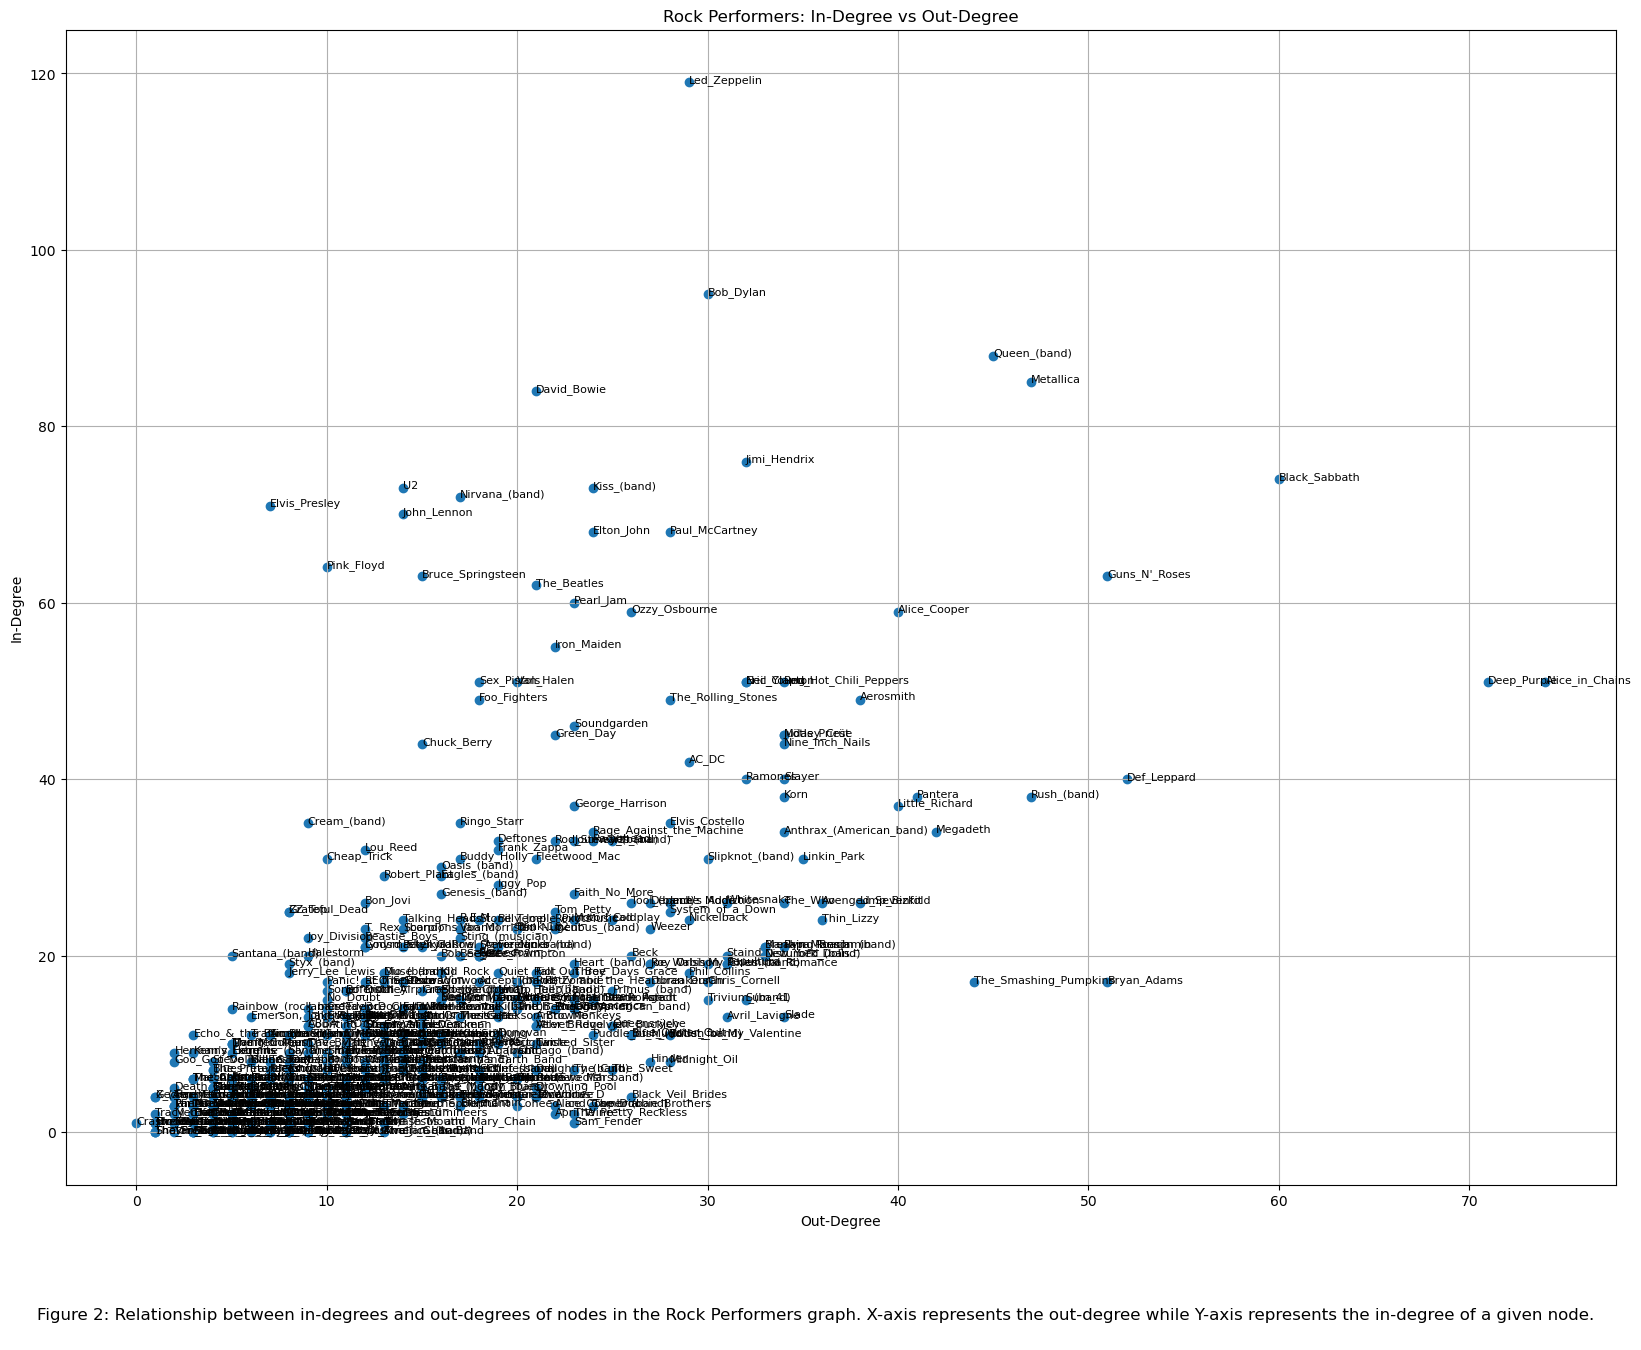

In [6]:
# Plot in-degree vs out-degree for each node
plt.figure(figsize=(20, 15))
plt.scatter(
    out_degrees_G,
    in_degrees_G,

)
for i, (in_deg, out_deg) in enumerate(zip(in_degrees_G, out_degrees_G)):
    plt.annotate(list(G.nodes)[i], (out_deg, in_deg), fontsize=8)
plt.title("Rock Performers: In-Degree vs Out-Degree")
plt.xlabel("Out-Degree")
plt.ylabel("In-Degree")
txt = f"Figure 2: Relationship between in-degrees and out-degrees of nodes in the Rock Performers graph. X-axis represents the out-degree while Y-axis represents the in-degree of a given node.\n"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.grid()
plt.show()

In general, we see a trend where in- and out-degrees follow eachother, i.e. there is a positive correlation. However, there is some noteable deviations, where some artists have a few in-degrees and a lot of out-degrees; to name one of the most prevelant Deep Purple. Contrarily, Elvis Presley has a lot of in-degrees but few out-degrees atleast to the expected correlation mentioned.

If this is investigated furthter on their Wikipage, we can see for Deep Purple they have whole section where multiple artists are referenced which have influenced them. Meanwhile, Elivs Presley does not have a lot of rock artists listed on his Wikipedia, this may suggest that he did not draw as much influence as he created. Moreover, on his page it is directly written that he was one of the primary infuential figures behind bands such as The Beatles.

In relation to aforementioned, if we list a few of the artists which have more in-degrees than out-degrees; Led Zeppelin, Jimi Hendrix, Nirvana, etc. We see that those are very popular names which may suggest that rock performers which have this property are usually forerunners. It should be noted that this is only applicable when the node has beyond a set number of degrees. For example, we could not draw the same conclusion the big pile of nodes in the lower left corner of Figure 2 which has a lot fewer degrees.

To view the correlation in the big pile of rock perfomers with a smaller amount of combined in- and out-degrees, we will plot a heatmap.

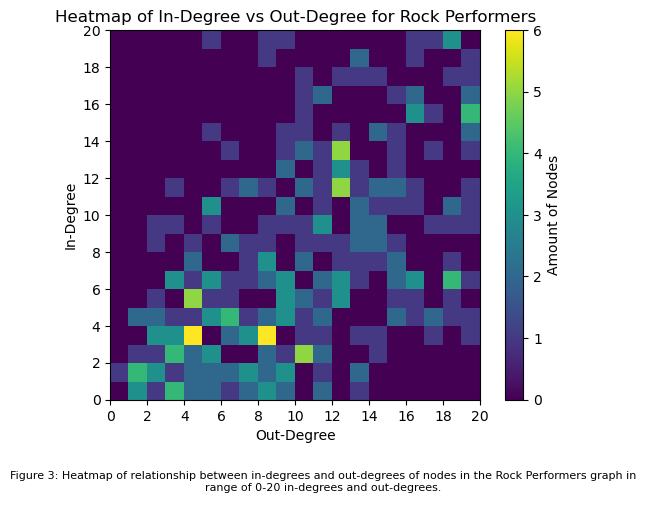

In [7]:
# Create a heatmap of in-degree vs out-degree 
heatmap, xedges, yedges = np.histogram2d(out_degrees_G, in_degrees_G, bins=20, range=[[0,20], [0,20]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar().ax.set_ylabel('Amount of Nodes')
plt.title('Heatmap of In-Degree vs Out-Degree for Rock Performers')
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))
plt.xlabel('Out-Degree')
plt.ylabel('In-Degree')
txt = f"Figure 3: Heatmap of relationship between in-degrees and out-degrees of nodes in the Rock Performers graph in range of 0-20 in-degrees and out-degrees.\n"
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=8)
plt.show()

While hightlighting the distribution in an otherwise unviewable part of Figure 2, the heatmap in Figure 3 shows a "skewed" positive correlation between in- and out degrees. This would suggest that rock perfomers with a small amount of total degrees seem to have a larger amount of outgoing relationships than ingoing. In other words, newer or smaller artists have drawn more influence than created influence such as larger artists mentioned earlier. 

Aforementioned does not explain the positive correlation itself, but this is most likely to artists collaborating with each other, as a collaboration between an artist would create a mutual connection between both, i.e. they would both gain an in- and out-going relation. As seen on Figure 2, whenever an artist have accumilated enough connections, they begin to deviate from the correlation seen with smaller artists which could suggest that at a certain point the artist has become big enough to not depend on collaborations to achieve success.

On the other hand, while collaborations and influence does have a major influence on the relationship between in- and out-degrees; the most crucial part is the overall content length on the Wikipedia page itself, but as the overall length of the page would indicate (to some degree) the popularity, or success of a specific artist, we will believe that it gives some good indication of an rock artists influence either way. 

### Assortivity and Centrality Analysis

We will highlight betweenness and eigenvector centrality for the top 10 artists, as well look at different assotivity measures for the network. Additionnally, a backbone of the Rock Performer Graph based on edge betweennes centrality will be investigated.

In [8]:
# Top 5 artists based on betweenness centrality 
betweenness_centrality = nx.betweenness_centrality(G)
sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

[('Deep_Purple', 0.04252725792366648),
 ('Queen_(band)', 0.03891913806261308),
 ('Alice_in_Chains', 0.0378875070822195),
 ("Guns_N'_Roses", 0.035105192172113595),
 ('Led_Zeppelin', 0.03395632688363857)]

In [9]:
# Top 5 artists based on eigenvector centrality 
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

[('Led_Zeppelin', 0.22369830224446516),
 ('Black_Sabbath', 0.1974119684314992),
 ('Metallica', 0.18728145782438774),
 ('Queen_(band)', 0.18317946120911432),
 ('Kiss_(band)', 0.16298619522075747)]

Comparing the two centrality measures, we see some reoccurring names such as Led Zeppelin and Deep Purple, suggesting that those artists are very central figures in the network. Betweenness and eigenvector centrality captures two different behaviours; respectively the amount of times a node is within the shortest path to other nodes, or the degree of an nodes influence to other influential nodes. As Led Zeppelin has the highest measure of eigenvector centrality, it could be suggested that Led Zeppelin has been the most influential rock artist within the network. Meanwhile, Deep Purple have been the most well connected within the network. Looking at figure 2, we also see that it is the case that Led Zeppelin is very prevelant with in-degrees, contrary to Deep Purple that has a high amount out-degrees.

In [10]:
# Degree assortativity coefficient for the graph
degree_assortativity = nx.degree_assortativity_coefficient(G)
print(degree_assortativity)

0.03945460744537188


In [11]:
# Attribute assortativity based on 'word_count' attribute
attribute_assortativity = nx.attribute_assortativity_coefficient(G, 'word_count')
print(attribute_assortativity)

-0.0024555538291297723


The assortivity does not reveal anything significant, except of course that there seems to be little to not assortivity based on both degrees and the word count attribute of the Rock Performer Graph. *Note word_count is the artists respective Wikipedia page's word count*

### Plotting Backbone Graph

For this last section, we will be plotting the Rock Performer Graph, but a backbone of it. This backbone is done by calculating the edge betweenness centrality of edges, and then using a backbone to calculate a "importance" score. Here it was found that removing edges with a score under 0.7 created a nice final plot.

In [12]:
# AI for nornmalizing edge betweenness centrality

G_undirected = G.to_undirected()
# Edge betweenness centrality: compute, normalize to 1-100, attach as edge attribute, show top 10
edge_betweenness = nx.edge_betweenness_centrality(G_undirected)

vals = np.array(list(edge_betweenness.values()), dtype=float)
min_v, max_v = vals.min(), vals.max()

if max_v == min_v:
    norm_vals = np.full_like(vals, 50.0)
else:
    norm_vals = 1.0 + (vals - min_v) * 99.0 / (max_v - min_v)

normalized_edge_betweenness_1_100 = {
    e: int(max(1, min(100, round(v))))
    for e, v in zip(edge_betweenness.keys(), norm_vals)
}

nx.set_edge_attributes(G_undirected, normalized_edge_betweenness_1_100, 'edge_betweenness_1_100')

In [13]:
# Export edge betweenness to CSV for backboning analysis
rows = []
for u, v, data in G_undirected.edges(data=True):
    rows.append({
        'src': u,
        'trg': v,
        'edge_betweenness_1_100': data['edge_betweenness_1_100']
    })

csv_output_path = os.path.join(wkd, 'rock_performers_edge_betweenness.csv')

df =  pd.DataFrame(rows)
df.to_csv(csv_output_path, index=False, sep='\t')

In [14]:
# Backboning analysis using noise-corrected method and disparity filter

table, nnodes, nnedges = backboning.read("rock_performers_edge_betweenness.csv", "edge_betweenness_1_100")
nc_table = backboning.noise_corrected(table)
nc_disparsity = backboning.disparity_filter(nc_table)
nc_backbone = backboning.thresholding(nc_disparsity, threshold=0.7) # found to be a good threshold for the plot
backboning.write(nc_backbone, "backboned_network", "nc", wkd)

Calculating NC score...
Calculating DF score...


In [15]:
# Copy initial graph structure, removing all edges and build backbone graph 
BACKBONE = G_undirected.copy()

BACKBONE.remove_edges_from(list(BACKBONE.edges()))

for idx, v in nc_backbone.iterrows():
    BACKBONE.add_edge(v['src'], v['trg'])

In [16]:
# Remove isolated nodes from the backbone graph
for node in list(nx.isolates(BACKBONE)):
    BACKBONE.remove_node(node)

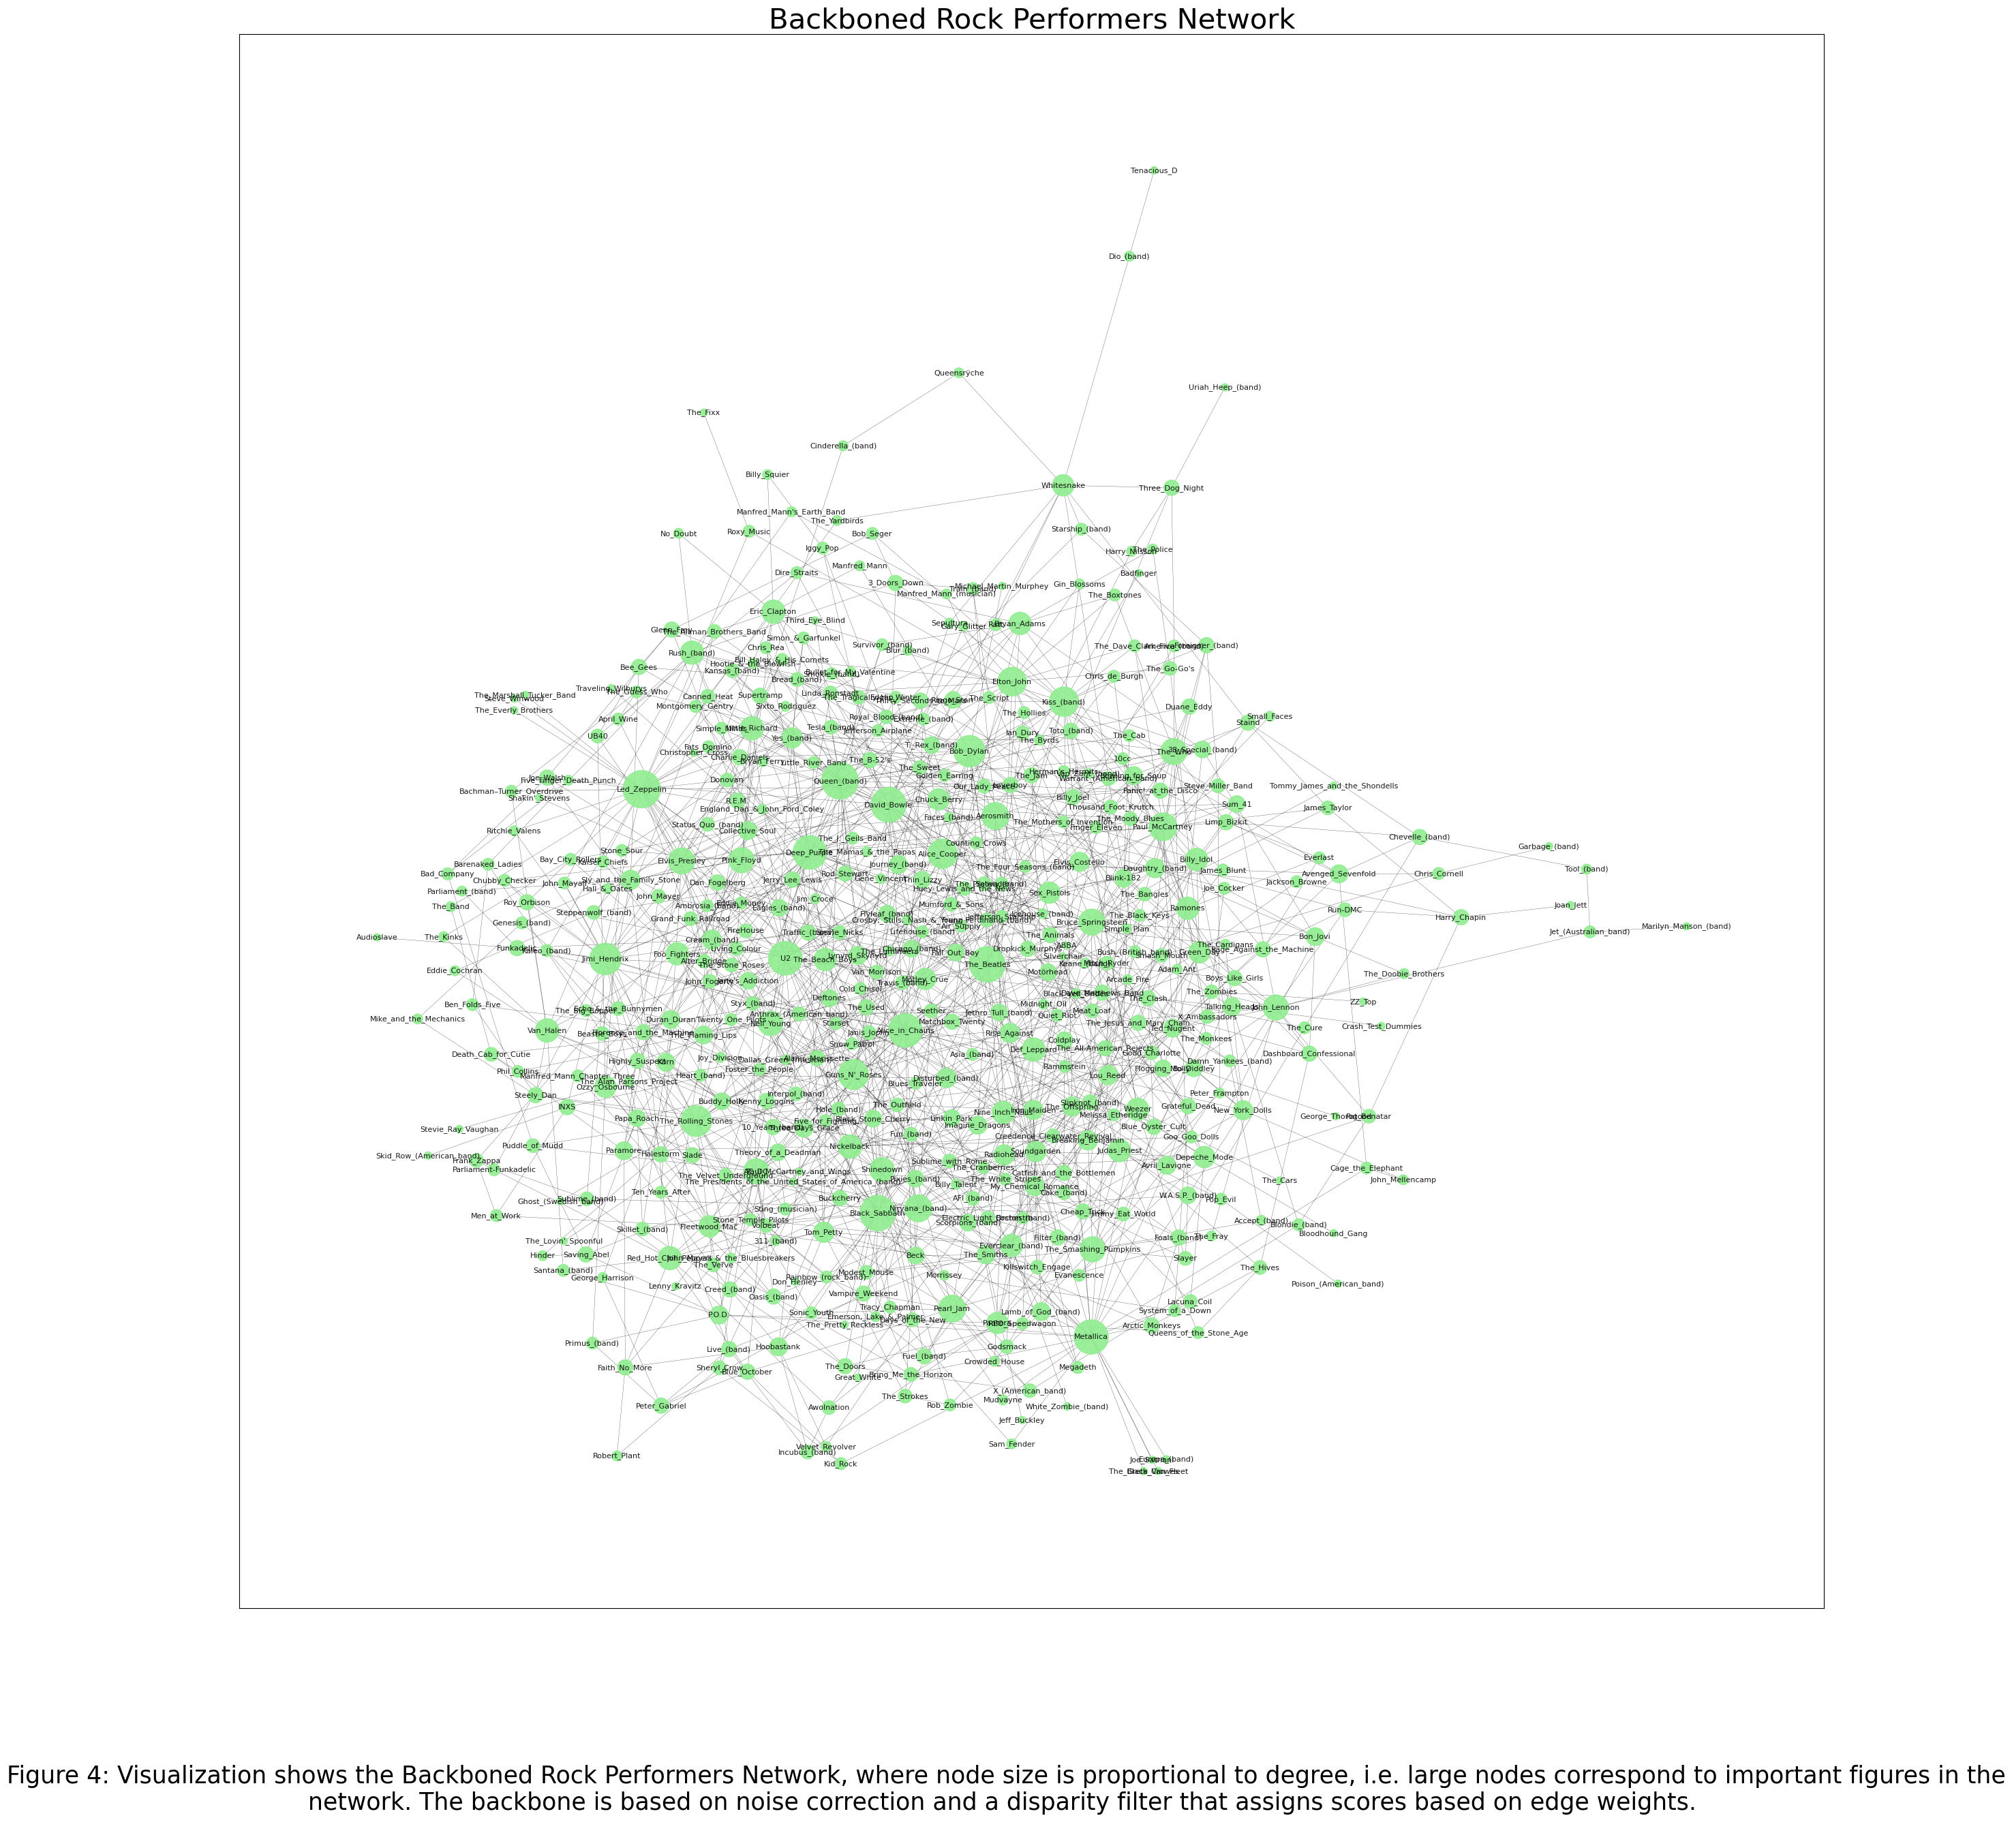

In [17]:
# Visualize the backboned network
pos = nx.forceatlas2_layout(BACKBONE, max_iter=1000, scaling_ratio=0.5, seed=50)

plt.figure(figsize=(30, 30))
nx.draw_networkx(
    BACKBONE,
    pos=pos,
    with_labels=True,
    font_size=8,
    width=0.2,
    alpha=0.9,
    node_size=[10 + 50 * nx.degree(BACKBONE, n) for n in BACKBONE.nodes()],
    node_color='lightgreen'
)
plt.title('Backboned Rock Performers Network', fontsize=30)
txt = f"Figure 4: Visualization shows the Backboned Rock Performers Network, where node size is proportional to degree, i.e. large nodes correspond to important figures in the network. The backbone is based on noise correction and a disparity filter that assigns scores based on edge weights. \n"
plt.figtext(0.5, 0, txt, wrap=True, horizontalalignment='center', fontsize=25)
plt.show()

In Figure 4, edges based on their betweenness centrality has been removed to reduce less important relations in the network, therefore scaling node sizes with their number of degrees will reveal which nodes has most amount of important edges. These finding are much in relation to the former section which discussed centrality, thus we also see many of the same nodes being of importance. As found in the former section, Led Zeppelin and Deep Purple are kept large, as the backbone sorting has deemed a majority of their edges important. This is most likely due to all the smaller nodes which has connection to formerly mentioned nodes has kept that specific edge, as the formerly metioned nodes are centrel artists of the graph. Therefore, nodes with high centrality measures will naturally keep many of their edges. 

In other words, as edges and nodes are removed based on importance, the visualization nicely highlights the important central figures of the Rock Performer Graph. Of cource, Led Zeppelin and Deep Purple are not the only central figures, but it was just to mention a few. Interestingly, Elvis Presley which was formerly mentioned in the analysis does not seem to have a large node  (we could not spot him at the time of writing this) which could indicate that he have been very influential to some of the large artists, but in general of the rock genre he is not a central figure. This could maybe also have been an issue of the articial edge weight, but still an interesting point.

## Part 2: Genres and communities and plotting

In [ ]:
# Load the network and create genre subgraph
G = nx.read_graphml(BASE / "rock_performers.graphml.xml").to_undirected()
genre_nodes = {n: artist_genres[n] for n in G if n in artist_genres}
genre_subgraph = G.subgraph(genre_nodes).copy()
genre_lcc = genre_subgraph.subgraph(max(nx.connected_components(genre_subgraph), key=len)).copy()

print(f"Base nodes {G.number_of_nodes()} | edges {G.number_of_edges()}")
print(f"Genre nodes {genre_subgraph.number_of_nodes()} | edges {genre_subgraph.number_of_edges()}")
print(f"Largest component {genre_lcc.number_of_nodes()} | edges {genre_lcc.number_of_edges()}")

### Genres and modularity

We extracted genres from the Wikipedia infoboxes for each artist. Most artists have multiple genres listed, so we needed to pick one for the modularity calculation. We tested a few approaches: using the first genre listed, using a random genre from the list, and just looking at the distribution.

The first genre approach gives us something to work with. We treat each unique genre as a community and see how well the network clusters around these labels.

In [ ]:
# Calculate genre statistics
first_partition = {n: g[0] for n, g in genre_nodes.items()}
all_genres = Counter(genre for genres in genre_nodes.values() for genre in genres)

print(f"Artists with genres: {len(genre_nodes)}")
print(f"Avg genres per artist: {np.mean([len(g) for g in genre_nodes.values()]):.2f}")
print(f"Distinct genres: {len(all_genres)}")
print(f"\nModularity (first genre): {modularity(genre_subgraph, first_partition):.4f}")

#### What is modularity?

Modularity measures how well a network splits into communities. It compares the actual connections inside communities to what you'd expect if edges were placed randomly while keeping node degrees the same. Higher modularity means nodes inside a community connect way more than they should by chance.

The formula from the book (equation 9.12) basically sums up, for each community, the fraction of edges inside minus the expected fraction squared. If you get a positive number, the partition has more structure than random. Values closer to 1 mean strong communities.

In [ ]:
# Test random genre selection
def random_partition(seed):
    rng = np.random.default_rng(seed)
    return {n: (g[0] if len(g) == 1 else rng.choice(g)) for n, g in genre_nodes.items()}

scores = np.array([modularity(genre_subgraph, random_partition(s)) for s in range(200)])
print("\nRandom genre selection modularity:")
print(pd.Series(scores).agg(["mean", "std", "min", "max"]))

The first genre modularity is around 0.095, which is pretty low. That makes sense because the "rock" genre is huge and dominates everything, dragging the score down. When we randomize which genre we pick for each artist, modularity drops to about 0.039. So the first genre still captures some structure, even if it's not great.

This tells us that Wikipedia's genre ordering probably reflects something real, but treating genres as hard communities isn't perfect for this network.

### Community detection with Louvain

Now we use the Louvain algorithm to find structural communities based purely on how artists link to each other, ignoring the genre labels completely.

In [ ]:
louvain = nx.algorithms.community.louvain.louvain_communities(genre_subgraph, seed=42)
louvain_partition = {n: f"c{i}" for i, community in enumerate(louvain) for n in community}

print(f"Louvain communities: {len(louvain)}")
print(f"Modularity (Louvain): {modularity(genre_subgraph, louvain_partition):.4f}")

Louvain gives us 5 communities with a modularity of about 0.348, which is way higher than the genre-based partition. This means the network actually has pretty strong structural communities that don't align perfectly with genre labels.

The difference suggests that how artists reference each other on Wikipedia reflects something beyond just genre. It could be related to era, geography, label affiliations, or other factors that create tighter clusters than genre alone.

### Confusion matrix: genres vs communities

To see how genres map to structural communities, we build a confusion matrix D. We take the top 7 genres and top 7 communities, then count how many artists appear in each genre-community pair.

In [ ]:
top_genres7 = [g for g, _ in all_genres.most_common(7)]
top_comms7 = [f"c{i}" for i, _ in sorted(((i, len(c)) for i, c in enumerate(louvain)), key=lambda x: x[1], reverse=True)[:7]]

confusion = pd.DataFrame({
    comm: [sum(1 for node in louvain[int(comm[1:])] if genre in genre_nodes[node]) for genre in top_genres7]
    for comm in top_comms7
}, index=top_genres7)

confusion

Looking at the confusion matrix, we can see some alignment but also a lot of mixing. Some communities lean towards specific genres (like alternative rock or hard rock), but the big "rock" genre spreads across multiple communities. This confirms that genre labels are pretty coarse and the network structure picks up on finer distinctions.

Communities c1 and c2 seem to capture alternative-leaning and hard rock artists pretty well. Community c4 has more pop-oriented acts. But overall, genres don't perfectly predict structural membership.

### Network visualization

We plot the largest connected component using a force-directed layout, coloring nodes by their Louvain community. This shows how the structural communities occupy distinct regions in the network.

In [ ]:
# Use spring layout as fallback
positions = nx.spring_layout(genre_lcc, seed=42, k=0.3, iterations=50)

palette = plt.get_cmap("tab20")
color_lookup = {f"c{i}": palette(i % palette.N) for i in range(len(louvain))}
node_colors = [color_lookup[louvain_partition[node]] for node in genre_lcc]

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(genre_lcc, positions, ax=ax, width=0.3, alpha=0.15)
nx.draw_networkx_nodes(genre_lcc, positions, ax=ax, node_size=20, node_color=node_colors)
ax.set_axis_off()
ax.set_title("Louvain communities")
plt.show()

The visualization shows clear clustering. The different colors (communities) tend to group together spatially, which makes sense given the high modularity. Even without knowing anything about genres, the link structure creates these distinct regions.

We can also look at the backbone edges (the strongest connections) overlaid with community colors to see if the core structure matches the communities.

In [ ]:
# Load backbone and plot
backbone = nx.read_graphml(BASE / "rock_performers_pruned.graphml.xml").to_undirected()
backbone_sub = backbone.subgraph(genre_lcc).copy()

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(backbone_sub, positions, ax=ax, width=0.8, alpha=0.4, edge_color="#666")
nx.draw_networkx_nodes(genre_lcc, positions, ax=ax, node_size=25, node_color=node_colors, edgecolors="#222", linewidths=0.3)
ax.set_axis_off()
ax.set_title("Backbone edges with community colors")
plt.show()

The backbone plot shows that the strongest connections mostly stay within communities, which aligns with the high modularity. A few inter-community connectionbs exist, but the core structure is pretty segregated.

Overall, the Louvain communities capture real structural patterns in how artists reference each other, and these patterns correlate with but aren't perfectly predicted by genre labels.

## Part 3: TF-IDF to understand genres and communities

### What is TF-IDF and why use it?

TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a way to figure out which words are important in a document by looking at how often they appear in that document compared to  how often they appear another place.

If a word shows up a lot in one genre but not in others, it's probably a central theme of that genre. Just counting word frequency (TF) gives you common words like "album" and "tour" that appear everywhere. TF-IDF de-prioritizes those generic/universal terms and highlights the unique vocabulary.

For our rock performers network, this helps us understand what makes each genre or community unique beyond generic music terms.

#### How TF-IDF works

We use log-scaled term frequency: 1 + log(count). This keeps really long pages from dominating while still rewarding repeated terms.

IDF measures how rare a word is across all documents. If a word appears in every genre, its IDF is low. If it only appears in a couple genres, IDF is high. We take the log to keep the numbers manageable.

Multiplying TF by IDF gives us the final score. Words that are both frequent in a document AND rare overall get the highest scores.

### Building TF-IDF for genres

We aggregate all text for each genre by combining artist pages that have that genre as their first label. Then we tokenize, remove stopwords, and calculate TF-IDF.

In [ ]:
top15 = [genre for genre, _ in all_genres.most_common(15)]
genre_token_counts = {genre: Counter() for genre in top15}
genre_page_counts = {genre: 0 for genre in top15}

for artist, genres in genre_nodes.items():
    primary = genres[0]
    if primary in genre_token_counts:
        tokens = tokens_for(artist)
        if tokens:
            genre_token_counts[primary].update(tokens)
            genre_page_counts[primary] += 1

# Filter rare words
filtered = {genre: Counter({word: count for word, count in counter.items() if count >= 5}) for genre, counter in genre_token_counts.items()}

coverage_summary = pd.DataFrame({
    "artists_counted": genre_page_counts,
    "unique_terms": {genre: len(filtered[genre]) for genre in top15}
}).sort_values("artists_counted", ascending=False)

coverage_summary

In [ ]:
# Calculate TF-IDF
N = len(top15)
doc_freq = Counter()
for genre in top15:
    doc_freq.update(filtered[genre].keys())

idf = {word: np.log(N / df) for word, df in doc_freq.items()}
log_tf = lambda count: 1 + np.log(count)

tfidf = {
    genre: Counter({
        word: log_tf(count) * idf[word]
        for word, count in filtered[genre].items()
        if idf.get(word, 0) > 0
    })
    for genre in top15
}

# Show top TF-IDF terms per genre
tfidf_top = pd.DataFrame(
    [(genre, word, score) for genre in top15 for word, score in tfidf[genre].most_common(10)],
    columns=["genre", "word", "tfidf"],
)

tfidf_ranked = tfidf_top.sort_values(["genre", "tfidf"], ascending=[True, False]).copy()
tfidf_ranked["rank"] = tfidf_ranked.groupby("genre")["tfidf"].rank(method="first", ascending=False).astype(int)
tfidf_ranked = tfidf_ranked.sort_values(["genre", "rank"])

tfidf_ranked.set_index(["genre", "rank"])

Looking at the top TF-IDF terms, we see genre-specific vocabulary emerge. Alternative metal highlights names like "cornell" and "evanescence", while blues rock surfaces "white" and "jack" (probably Jack White and The White Stripes). Pop-oriented genres keep chart-related terms like "billboard" and "number".

This is way more informative than raw word counts, which just gave us generic tour and album talk.

### Word clouds for genres

In [ ]:
cols = 5
rows_plot = int(np.ceil(len(top15) / cols))

if WORDCLOUD_AVAILABLE:
    fig, axes = plt.subplots(rows_plot, cols, figsize=(15, 3 * rows_plot))
    axes = np.atleast_2d(axes)
    for ax, genre in zip(axes.ravel(), top15):
        weights = {word: score for word, score in tfidf[genre].items() if score > 0}
        if weights:
            max_score = max(weights.values())
            scaled = {word: score / max_score for word, score in weights.items()}
            img = WordCloud(width=400, height=300, background_color="white", colormap="tab20", collocations=False).generate_from_frequencies(scaled)
            ax.imshow(img, interpolation="bilinear")
            ax.set_title(genre)
        ax.axis("off")
    for ax in axes.ravel()[len(top15):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("WordCloud not installed; showing top TF-IDF tokens per genre instead.")
    display(tfidf_ranked.head(50))

The wordclouds make the genre distinctions pretty clear. Alternative genres feature specific band names, blues rock highlights signature artists, and pop genres emphasize chart success. Generic music terms like "album" and "released" fade into the background since TF-IDF down-weights them.

One thing to note: we normalize each genre's TF-IDF scores by its own maximum before plotting. This keeps the wordcloud readable and prevents one extremely distinctive term from dominating the visualization.

### TF-IDF for communities

Now we do the same thing but for the Louvain communities instead of genres. This shows us what vocabulary characterizes each structural community.

In [ ]:
# Build TF for communities
top_comms_ids = [i for i, _ in sorted(((i, len(c)) for i, c in enumerate(louvain)), key=lambda x: x[1], reverse=True)[:15]]
comm_token_counts = {f"c{i}": Counter() for i in top_comms_ids}
comm_page_counts = {f"c{i}": 0 for i in top_comms_ids}

for artist, comm in louvain_partition.items():
    if comm in comm_token_counts:
        tokens = tokens_for(artist)
        if tokens:
            comm_token_counts[comm].update(tokens)
            comm_page_counts[comm] += 1

filtered_comm = {comm: Counter({word: count for word, count in counter.items() if count >= 5}) for comm, counter in comm_token_counts.items()}

# Calculate TF-IDF for communities
N_comm = len(filtered_comm)
doc_freq_comm = Counter()
for comm in filtered_comm:
    doc_freq_comm.update(filtered_comm[comm].keys())

idf_comm = {word: np.log(N_comm / df) for word, df in doc_freq_comm.items()}

tfidf_comm = {
    comm: Counter({
        word: log_tf(count) * idf_comm[word]
        for word, count in filtered_comm[comm].items()
        if idf_comm.get(word, 0) > 0
    })
    for comm in filtered_comm
}

# Show top terms
tfidf_comm_top = pd.DataFrame(
    [(comm, word, score) for comm in filtered_comm for word, score in tfidf_comm[comm].most_common(10)],
    columns=["community", "word", "tfidf"],
)

tfidf_comm_ranked = tfidf_comm_top.sort_values(["community", "tfidf"], ascending=[True, False]).copy()
tfidf_comm_ranked["rank"] = tfidf_comm_ranked.groupby("community")["tfidf"].rank(method="first", ascending=False).astype(int)
tfidf_comm_ranked = tfidf_comm_ranked.sort_values(["community", "rank"])

tfidf_comm_ranked.set_index(["community", "rank"])

In [ ]:
# Word clouds for communities
if WORDCLOUD_AVAILABLE:
    fig, axes = plt.subplots(rows_plot, cols, figsize=(15, 3 * rows_plot))
    axes = np.atleast_2d(axes)
    for ax, comm in zip(axes.ravel(), filtered_comm.keys()):
        weights = {word: score for word, score in tfidf_comm[comm].items() if score > 0}
        if weights:
            max_score = max(weights.values())
            scaled = {word: score / max_score for word, score in weights.items()}
            img = WordCloud(width=400, height=300, background_color="white", colormap="tab20", collocations=False).generate_from_frequencies(scaled)
            ax.imshow(img, interpolation="bilinear")
            ax.set_title(comm)
        ax.axis("off")
    for ax in axes.ravel()[len(filtered_comm):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("WordCloud not installed; showing top TF-IDF tokens per community instead.")
    display(tfidf_comm_ranked.head(50))

### Comparing genres and communities

Using the confusion matrix D from earlier, we can see which genres align with which communities. Some communities have clear genre associations based on the wordclouds.

For example, communities with high alternative rock counts in the confusion matrix also show alternative-related words in their TF-IDF wordclouds. Communities with more pop artists feature chart-related words.

But there's also differences. Some structural communities group artists that cross multiple genres but share other characteristics, maybe they're from the same time or region. The TF-IDF analysis helps show these patterns that genres alone cannot show.

Overall, genre wordclouds tend to be more coherent because genres are explicitly defined categories. Community wordclouds are messier but can reveal unexpected groupings based on the network structure. Both perspectives are useful for understanding the dataset.

### Part 4: Sentiment of the artists and communities

#### Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.

In [ ]:
from pathlib import Path
import urllib.request

# Download LabMT wordlist - using the correct URL from the hedonometer project
labmt_url = "https://raw.githubusercontent.com/andyreagan/labMT-simple/master/data/labMT2english.txt"
labmt_path = Path("labMT2english.txt")

if not labmt_path.exists():
    print("Downloading LabMT wordlist...")
    try:
        urllib.request.urlretrieve(labmt_url, labmt_path)
        print("Download complete!")
    except:
        # Alternative: download from the original paper's supplementary materials
        print("Primary source failed, trying alternative source...")
        labmt_url_alt = "https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001"
        urllib.request.urlretrieve(labmt_url_alt, labmt_path)
        print("Download complete from alternative source!")
else:
    print("LabMT wordlist already exists.")

# Load the LabMT scores into a dictionary
labmt_scores = {}
with open(labmt_path, 'r', encoding='utf-8') as f:
    next(f)  # Skip header
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            word = parts[0].lower()
            try:
                happiness_avg = float(parts[2])
                labmt_scores[word] = happiness_avg
            except ValueError:
                continue

print(f"Loaded {len(labmt_scores)} words with sentiment scores")
print(f"Sample words: {list(labmt_scores.items())[:5]}")

Next we define a function to calculate the average senteminet score for a input text.

In [ ]:
def _get_sentiment_score(word):
    """Retrieve the sentiment score for a given word from the LabMT dictionary."""
    return labmt_scores.get(word.lower(), None)

def analyze_sentiment(text):
    """Analyze the sentiment of a given text using the LabMT wordlist."""
    words = text.split()
    scores = []
    for word in words:
        score = _get_sentiment_score(word)
        if score is not None:
            scores.append(score)
    
    if scores:
        average_score = sum(scores) / len(scores)
        return average_score
    else:
        return None

Then we load the graph with genres.

In [ ]:
G = nx.read_gml("graph_with_genres.gml")

And then we caclulate the sentiment score for each band page. We use a parser to remove wikicode, so the sentiment is only calculated on the text and not symbols.

In [ ]:
for node in G.nodes():
    node_text_path = Path(f"data/performers/{node}.txt")
    if node_text_path.exists():
        with open(node_text_path, 'r', encoding='utf-8') as f:
            node_text = f.read()
            node_wikicode = mwparserfromhell.parse(node_text)
            plain_text = node_wikicode.strip_code() # extract plain text from wikicode
            node_sentiment = analyze_sentiment(plain_text)
            G.nodes[node]['sentiment'] = node_sentiment
    else:
        print(f"Text file for node {node} does not exist.")

We calculate some describtive statistics and plot the distribution of sentiments.

In [ ]:
import numpy as np
sentiments = [data['sentiment'] for _, data in G.nodes(data=True)]

average_sentiment = np.mean(sentiments)
median_sentiment = np.median(sentiments)
variance_sentiment = np.var(sentiments)
percentile_25 = np.percentile(sentiments, 25)
percentile_75 = np.percentile(sentiments, 75)

print(f"Average Sentiment: {average_sentiment:.4f}")
print(f"Median Sentiment: {median_sentiment:.4f}")
print(f"Variance of Sentiment: {variance_sentiment:.4f}")
print(f"25th Percentile: {percentile_25:.4f}")
print(f"75th Percentile: {percentile_75:.4f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

bins, edges = np.histogram(sentiments, bins=20)

sns.set(style="whitegrid", context="talk", palette="rocket")
fig, ax = plt.subplots(figsize=(12, 6))

# Histogram (using previously computed edges) and KDE overlay
ax.hist(sentiments, bins=edges, density=True,
    color=sns.color_palette("rocket")[5], alpha=0.9, edgecolor='white', linewidth=1.2)
sns.kdeplot(sentiments, bw_method="scott", ax=ax, color=sns.color_palette("rocket")[4], lw=3)

# Rug plot for individual points
sns.rugplot(sentiments, ax=ax, color="k", alpha=0.25)

# statistics as vertical lines
ax.axvline(average_sentiment, color="#1b9e77", lw=2.5, linestyle='--', label=f"Mean: {average_sentiment:.3f}")
ax.axvline(median_sentiment, color="#d95f02", lw=2, linestyle='-.', label=f"Median: {median_sentiment:.3f}")
ax.axvline(percentile_25, color="#7570b3", lw=3, linestyle=':', label=f"25th pct: {percentile_25:.3f}")
ax.axvline(percentile_75, color="#e72929", lw=3, linestyle=':', label=f"75th pct: {percentile_75:.3f}")

# Stats text box
stats_text = (
    f"N = {len(sentiments)}\n"
    f"Mean = {average_sentiment:.3f}\n"
    f"Median = {median_sentiment:.3f}\n"
    f"Variance = {variance_sentiment:.4f}\n"
    f"25th = {percentile_25:.3f}\n"
    f"75th = {percentile_75:.3f}"
)

# Labels, title and final styling
ax.set_title("Artist Page Sentiments", fontsize=18, weight="bold")
ax.set_xlabel("Sentiment score (LabMT)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
sns.despine(trim=True)
ax.set_facecolor("#fbfbfb")
ax.legend(frameon=True, loc="upper left")

plt.tight_layout()
plt.show()

Looking at the statistics and visualization above, it is clear that there is little variation in sentiment among rock bands. The sentiment scores follow a near-normal distribution centered around 5.5, with a narrow interquartile range. This suggests that the text content on Wikipedia pages tends to be fairly neutral, likely because the writing is mostly descriptive rather than subjective. Nevertheless, the aspects that may contribute most to sentiment differences are the bands’ personalities, controversies, and creative outputs, such as album and song titles, since some rock bands explore darker, more emotional themes while others focus on lighter or more uplifting topics.

We also find the 10 saddest and happiest bands.

In [ ]:
# print the nodes with highest and lowest sentiment
sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1].get('sentiment'))
print("10 Saddest Artists:")
print("-------------------")
for i, (node, data) in enumerate(sorted_nodes[:10]):
    print(f"{i+1}. {node}: {round(data.get('sentiment'), 2)}")

print("\n10 Happiest Artists:")
print("--------------------")
for i, (node, data) in enumerate(sorted_nodes[-10:][::-1]):
    print(f"{i+1}. {node}: {round(data.get('sentiment'), 2)}")

Analyzing the happiest and saddest artists, we recognize some familiar names. For instance, Marilyn Manson unsurprisingly appears among the saddest, known for his dark and often satanic musical themes. On the happier side, we find Tracy Chapman, who is better known for her uplifting and soulful pop-rock songs. This further supports the idea that differences in sentiment likely stem from subtle variations in descriptive language rather than strong emotional bias, as Wikipedia articles generally maintain a neutral tone.

#### Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

In [ ]:
# load genre subgraph
genre_subgraph = nx.read_gml("genre_subgraph.gml")
louvain = nx.algorithms.community.louvain.louvain_communities(genre_subgraph, seed=42)
print(f"Louvain communities: {len(louvain)}")

# print 3 most connected bands in each community
for i, community in enumerate(louvain):
    community_sentimnts = []
    subgraph = genre_subgraph.subgraph(community)
    degrees = subgraph.degree()
    sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
    print(f"\nCommunity {i+1}:")
    print("-------------------")
    for j, (node, degree) in enumerate(sorted_degrees[:3]):
        print(f"{j+1}. {node}: Degree {degree}, Genre: {genre_subgraph.nodes[node].get('genre')}")
    
    for node in subgraph.nodes(data=True):
        sentiment = G.nodes[node[0]].get('sentiment')
        community_sentimnts.append(sentiment)
    avg_community_sentiment = np.mean(community_sentimnts)
    print(f"Average Sentiment of Community {i+1}: {avg_community_sentiment:.3f}")

Analyzing the communities above, we observe that all exhibit average sentiment values within a narrow range (5.467–5.549), suggesting that none of the groups express strongly positive or negative tones compared to one another. This consistency indicates a generally neutral or mildly positive discourse across the dataset. Notably, Community 4 shows the highest average sentiment, and its most connected nodes—Collective Soul, Counting Crows, and Everclear, belong to the alternative rock genre. This aligns with the TF-IDF findings, as alternative rock pages tend to feature promotion-heavy vocabulary such as “new,” “single,” and “live,” reflecting release cycles and touring activities that contribute to a slightly more positive but still relatively neutral tone.